# Imports

In [1]:
import os
from importlib import reload

from sign_language_translator.vision import visualization as vis
from sign_language_translator.vision import transforms as T
from sign_language_translator.vision import concatenate as C

import moviepy.editor as mpy
import numpy as np
from IPython.display import Image, Video, clear_output

# reload(C)
clear_output()

# Load demo data

In [2]:
word = 'd-D'
# file reading
pose_multi_frame_landmarks = np.loadtxt(os.path.join('inputs', f'pose_{word}_person205_front.csv'), skiprows=1,delimiter=',')
hand_multi_frame_landmarks = np.loadtxt(os.path.join('inputs', f'hand_{word}_person205_front.csv'), skiprows=1,delimiter=',')

# fix error (mirror hands horizontally)
hand_multi_frame_landmarks[..., np.arange(42)*3] *= -1

# stacking
all_multi_frame_landmarks = np.concatenate([pose_multi_frame_landmarks,
                                            hand_multi_frame_landmarks], axis=-1)

idx = 37
pose = pose_multi_frame_landmarks[idx]
hand = hand_multi_frame_landmarks[idx]
all_ =  all_multi_frame_landmarks[idx]

n_frames= len(all_multi_frame_landmarks)

# Concatenate

##### `Trimming Algorithm`

['گا', 'جاؤں', 'سکول', 'سے', 'بس', 'میں']
['I', 'bus', 'from', 'school', 'go', 'will']
  I will go to school on the bus.


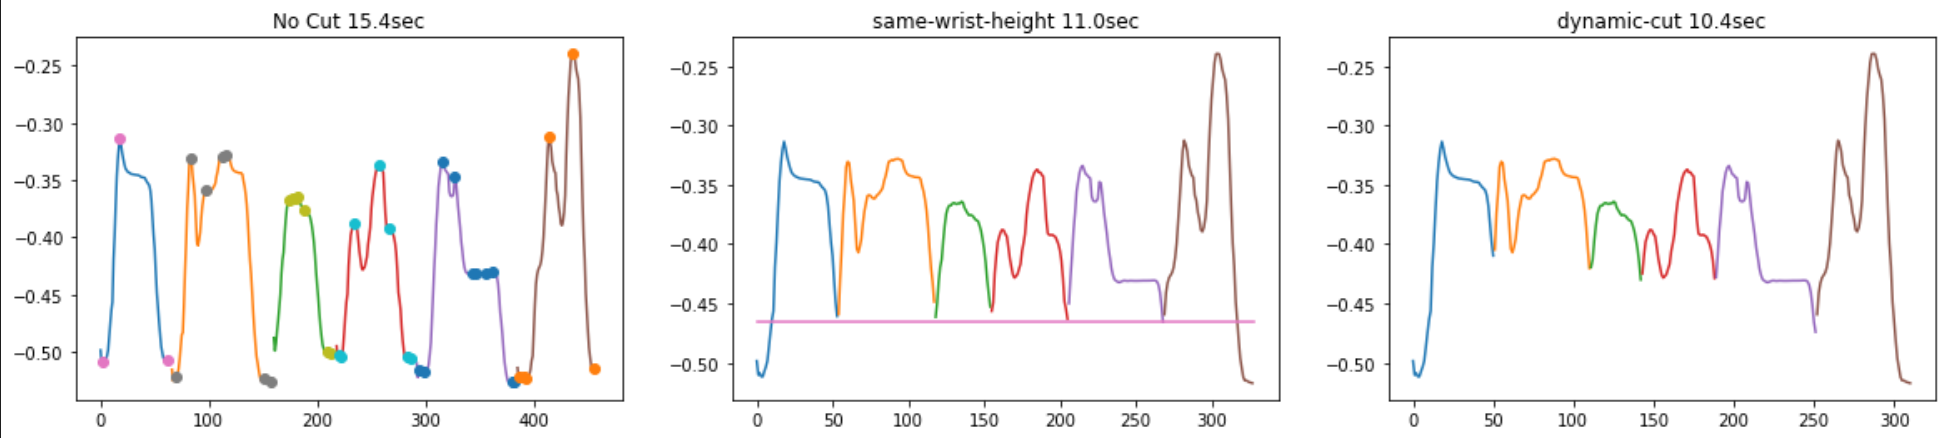

In [8]:
# The graphs shows the vertical movement of the right wrist during the printed list of words

# The left one shows the unchanged movement with the peaks and plateaus marked on the curves with a 'o'.

# The middle one shows the results of a strategy where videos are cut when the wrist reaches a particular height.
# The results were not much fun nor robust.

# The right one shows the results of the concatenation technique actually used.
# it picks 70% of the height of the peak near the end of video_1 and the peak near the start of video_2.
# the shorter height is selected and both videos are cut when the wrist last/first reaches that height .

print("['گا', 'جاؤں', 'سکول', 'سے', 'بس', 'میں']\n['I', 'bus', 'from', 'school', 'go', 'will']\n  I will go to school on the bus.")
Image('inputs/wirst_vertical_movements.png')

## `Concatenate Landmarks`

In [3]:
landmarks_list = [all_multi_frame_landmarks]*5
cat_1 = C.concatenate_landmarks(
    landmarks_list,
    n_transition_frames=5,
    trim=True,
    # optional:
    infer_cut_indexes=True, # figure out how much to trim each video
    landmark_number_to_track=16, # right wrist.. (some times left wrist 15 should be tracked)
    rectify_for_infering_cut_indexes=True, # internally fix rotation in landmarks before tracking
    coordinate_type='3D', # helps in rectification
    landmarks_to_use_for_rectification=[11, 12, 23, 24], # torso
    max_cut_steps=25, # maximum number of frames to trim
    tolarance_val=0.02, # this + the lowest level of tracked landmark is the threshold to start tracking
    height_frac=0.7, # cut at 70% height of the edge peak
)

rotated_landmarks = [
    T.rotate_landmarks(
        all_multi_frame_landmarks,
        *(np.random.rand(3)-0.5)*180,
        in_degrees=True,
    )
    for _ in range(5)
]
cat_2 = C.concatenate_landmarks(rotated_landmarks, trim=True, n_transition_frames=5)

clip_1 = vis.multi_frame_landmarks_to_video(cat_1, fig_height=6, fig_width=6)
clip_2 = vis.multi_frame_landmarks_to_video(cat_2, fig_height=6, fig_width=6)

stacked_clip = mpy.clips_array([[clip_1,clip_2]])
try: stacked_clip.write_videofile(os.path.join('outputs','trimmed_transitioned.mp4'))
except IndexError: pass
[c.close() for c in [clip_1,clip_2,stacked_clip]]
clear_output()

In [36]:
Video(os.path.join('outputs','trimmed_transitioned.mp4'), html_attributes='loop autoplay')

## `Concatenate Videos`

In [5]:
clip = mpy.VideoFileClip(os.path.join('inputs','d-D_person205_front.mp4'))

clip_ = C.concatenate_clips(
    [clip]*3,
    trim=True,
    triming_reference_landmarks=[pose_multi_frame_landmarks]*3,
    n_transition_frames=5,
    coordinate_type='3D', # use 2d Image coordinates for best results
    rectify_landmarks=True,
)

try: clip_.resize(height=600).write_videofile(os.path.join('outputs','clip_concat.mp4')), clear_output()
except IndexError as e: print(e)
clip.close()
clip_.close()